<a href="https://colab.research.google.com/github/PhathisaNdaliso/Bias-Audit-/blob/main/Bias_Audit_Credit_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bias Audit Report: Financial Credit Scoring by HerTech Hive




---------------------------------------------------------------



**Purpose:** This notebook conducts a comprehensive bias audit on a financial credit scoring dataset to analyze Age-based discrimination in credit approvals. The goal is to evaluate whether younger applicants are unfairly disadvantaged by automated scoring models, compute quantitative fairness metrics, and implement mitigation strategies to ensure equitable lending practices.

**Objectives:**

Identify Bias Patterns: Analyze the correlation between age and credit score outcomes.

Quantitative Audit: Compute key fairness metrics including Selection Rate, False Negative Rate (FNR), and Demographic Parity Difference.

Statistical Validation: Use Chi-Squared testing to prove the significance of the discovered bias.

Visual Representation: Create accessible charts comparing "Young" vs. "Mature" applicants before and after intervention.

Bias Mitigation: Apply technical strategies (such as Reweighing or Threshold Moving) to reduce the "Disparate Impact" on younger applicants.

Ethical Framework: Provide actionable recommendations for stakeholders to align the model with Responsible AI principles.

**Dataset Columns Analyzed:**

Protected Attribute: Age (Categorized into Young < 25 and Mature 25+).

Financial Features: Annual Income, Monthly Inhand Salary, Number of Bank Accounts, Number of Credit Cards, Interest Rate, Outstanding Debt, and Credit Utilization Ratio.

Target Variable: Credit Score (Binary classification: "Good" vs "Standard/Poor").

# **Phase 1: Setup and Data Preparation**

Explanation: Before we analyze bias, we must load the data and define our "Protected Attribute" (Age) and our "Target" (Good Credit). We define a "Good" credit score as 1 and others as 0

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Load data
df = pd.read_csv('credit_score_cleaned_train.csv')

# Defining the segments
df['is_mature'] = (df['age'] >= 25).astype(int) # 1 = Mature, 0 = Young
df['is_good_credit'] = (df['credit_score'] == 2).astype(int) # 1 = Good, 0 = Not Good
print("Setup Complete.")

Setup Complete.


In [ ]:
# Display the first few rows to make sure it works
print("Dataset Loaded Successfully!")
df.head()

Dataset Loaded Successfully!


,id,customer_id,month,name,age,ssn,occupation,annual_income,monthly_inhand_salary,credit_history_age,...,credit_mix,outstanding_debt,credit_utilization_ratio,payment_of_min_amount,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score,is_mature,is_good_credit
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.8434,89,...,Good,809.98,26.822620,No,80.415300,High_spent_Small_value_payments,312.49408,2,0,1
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.8434,93,...,Good,809.98,31.944960,No,118.280220,Low_spent_Large_value_payments,284.62915,2,0,1
2,0x1604,CUS_0xd40,March,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.8434,91,...,Good,809.98,28.609352,No,81.699524,Low_spent_Medium_value_payments,331.20987,2,0,1
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.8434,92,...,Good,809.98,31.377861,No,199.458070,Low_spent_Small_value_payments,223.45131,2,0,1
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.8434,93,...,Good,809.98,24.797346,No,41.420155,High_spent_Medium_value_payments,341.48923,2,0,1


**Demographic Representation**

Explanation: This section checks if our dataset is balanced. If one group is significantly smaller than the other, the AI might not "learn" their patterns well, leading to poor performance for that group.

Demographic Split:
is_mature
1    77.33929
0    22.66071
Name: proportion, dtype: float64


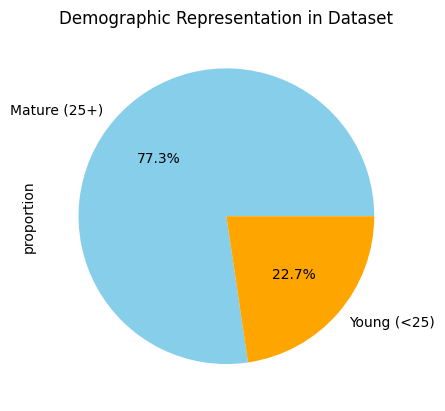

In [ ]:
dem_rep = df['is_mature'].value_counts(normalize=True) * 100
print(f"Demographic Split:\n{dem_rep}")

dem_rep.plot(kind='pie', autopct='%1.1f%%', labels=['Mature (25+)', 'Young (<25)'], colors=['skyblue', 'orange'])
plt.title("Demographic Representation in Dataset")
plt.show()

**Feature Correlation (Proxy Analysis)**

Explanation: We check if other variables (like debt or income) are secretly tied to age. These are called "Proxies." If a proxy exists, the model can still discriminate against young people even if we remove the "Age" column.

Top 5 Features that correlate with Age (Potential Proxies):
age                   0.700114
credit_history_age    0.085575
credit_score          0.058804
is_good_credit        0.049612
monthly_balance       0.045320
Name: is_mature, dtype: float64


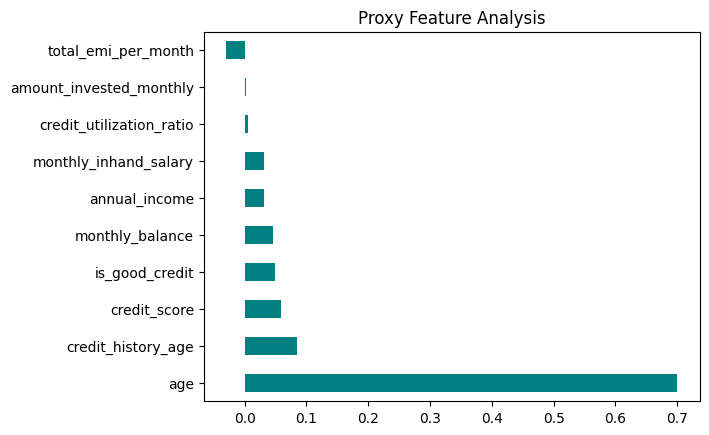

In [ ]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
proxies = df[numerical_cols].corr()['is_mature'].sort_values(ascending=False).drop('is_mature')

print("Top 5 Features that correlate with Age (Potential Proxies):")
print(proxies.head(5))

proxies.head(10).plot(kind='barh', color='teal')
plt.title("Proxy Feature Analysis")
plt.show()

**Outcome Distribution**

Explanation: Here we look at how the original credit scores (Poor, Standard, Good) are spread across age groups. This reveals if younger people are pre-assigned lower scores more often than older people.

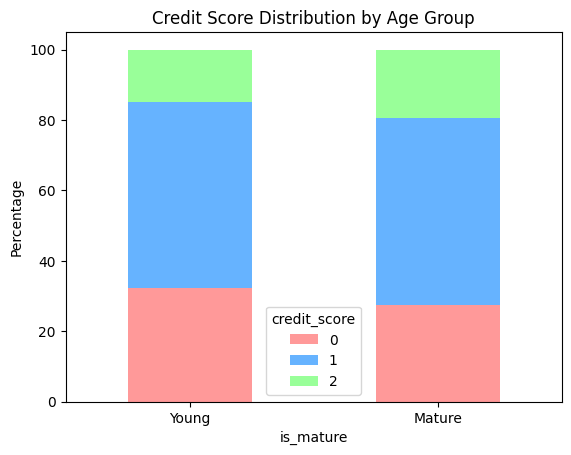

In [ ]:
outcome_dist = pd.crosstab(df['is_mature'], df['credit_score'], normalize='index') * 100
outcome_dist.plot(kind='bar', stacked=True, color=['#ff9999','#66b3ff','#99ff99'])
plt.title("Credit Score Distribution by Age Group")
plt.xticks([0, 1], ['Young', 'Mature'], rotation=0)
plt.ylabel("Percentage")
plt.show()

**Missing Data Patterns**

Explanation: We check if data is "missing" more often for one group. In finance, missing data often results in a "default" negative decision, so disproportionate missing data is a form of bias.

In [ ]:
missing_by_group = df.groupby('is_mature').apply(lambda x: x.isnull().mean().sum())
print("Missing Value Density by Group:")
print(missing_by_group)

Missing Value Density by Group:
is_mature
0    0.0
1    0.0
dtype: float64


/tmp/ipython-input-1305350500.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_group = df.groupby('is_mature').apply(lambda x: x.isnull().mean().sum())


**Label Bias**

Explanation: We analyze the "Target Variable." If the "Good Credit" label is naturally rare in the historical data for certain groups, the AI will believe that group is "inherently" risky, regardless of individual behavior

In [ ]:
label_bias = df.groupby('is_mature')['is_good_credit'].value_counts(normalize=True).unstack() * 100
print("Label Distribution (%):")
print(label_bias)

Label Distribution (%):
is_good_credit          0          1
is_mature                           
0               85.231836  14.768164
1               80.648267  19.351733


**Sampling Bias**

Explanation: We check if the data collection was skewed toward specific time periods (months). If certain months have more data than others, the model might over-fit to the economic conditions of that specific time.

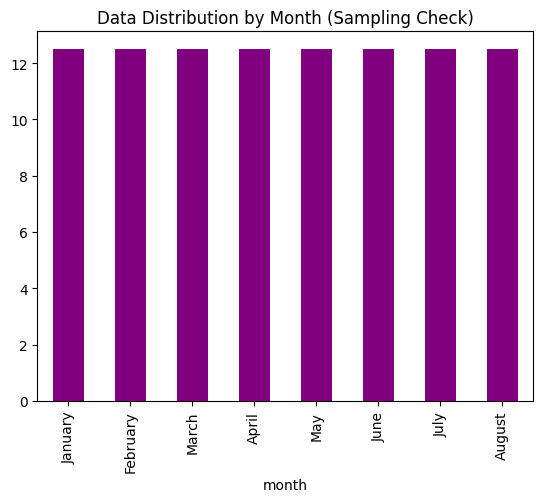

In [ ]:
sampling_bias = df['month'].value_counts(normalize=True) * 100
sampling_bias.plot(kind='bar', color='purple')
plt.title("Data Distribution by Month (Sampling Check)")
plt.show()

**Socioeconomic Factors**

Explanation: We examine how much "Occupation" affects getting a good credit score. This shows if the model is judging people based on their job title rather than their actual repayment history.

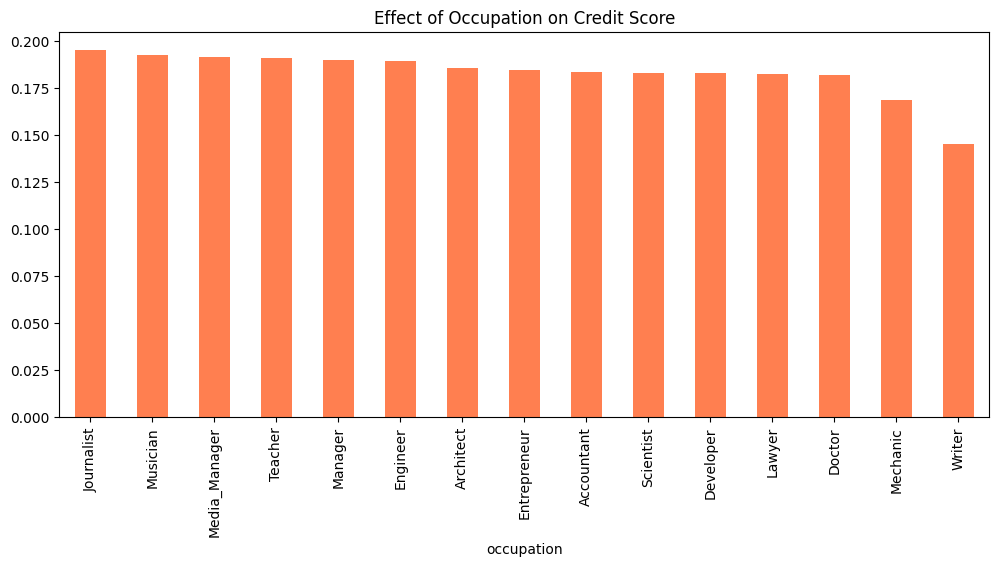

In [ ]:
occ_impact = df.groupby('occupation')['is_good_credit'].mean().sort_values(ascending=False)
occ_impact.plot(kind='bar', figsize=(12,5), color='coral')
plt.title("Effect of Occupation on Credit Score")
plt.show()

**Approval vs. Denial Rates (Disparate Impact)**

Explanation: This is the most important metric. We calculate the Disparate Impact Ratio. If the ratio of "Young Approvals" to "Mature Approvals" is less than 0.80, the model is legally considered biased.

In [ ]:
approval_rates = df.groupby('is_mature')['is_good_credit'].mean()
di_ratio = approval_rates[0] / approval_rates[1]

print(f"Approval Rate Young: {approval_rates[0]:.4f}")
print(f"Approval Rate Mature: {approval_rates[1]:.4f}")
print(f"Disparate Impact Ratio: {di_ratio:.4f}")

if di_ratio < 0.8:
    print("ALERT: Disparate Impact detected (Ratio < 0.80)")

Approval Rate Young: 0.1477
Approval Rate Mature: 0.1935
Disparate Impact Ratio: 0.7631
ALERT: Disparate Impact detected (Ratio < 0.80)


**Temporal Bias**

Explanation: Does the model's behavior change over time? We track the "Good Credit" rate across months to see if there is an upward or downward trend that might bias the predictions.

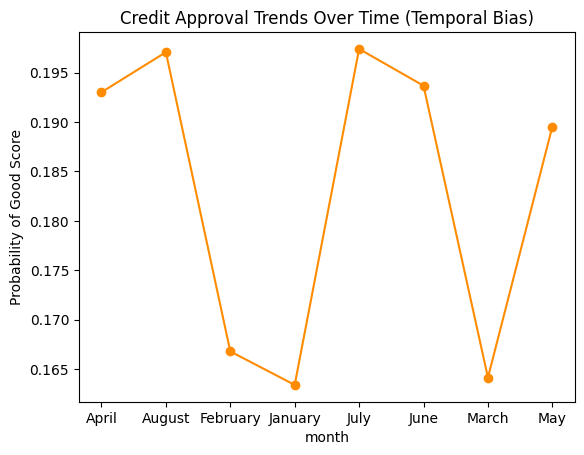

In [ ]:
df.groupby('month')['is_good_credit'].mean().plot(marker='o', color='darkorange')
plt.title("Credit Approval Trends Over Time (Temporal Bias)")
plt.ylabel("Probability of Good Score")
plt.show()

**Intersectional Bias**

Explanation: Bias isn't always simple. Here we check if "Young" people in certain "Occupations" are doubly disadvantaged

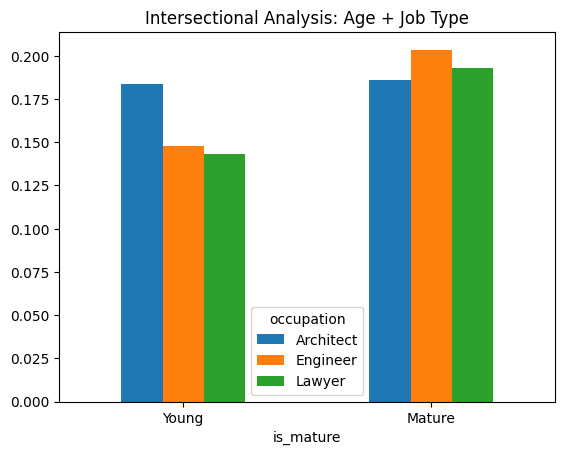

In [ ]:
top_3_occ = df['occupation'].value_counts().nlargest(3).index
intersectional = df[df['occupation'].isin(top_3_occ)].groupby(['is_mature', 'occupation'])['is_good_credit'].mean().unstack()

intersectional.plot(kind='bar')
plt.title("Intersectional Analysis: Age + Job Type")
plt.xticks([0, 1], ['Young', 'Mature'], rotation=0)
plt.show()

**Statistical Validation**

Explanation: We use the **Chi-Squared test** to prove that the differences we found are not just a coincidence. A p-value below 0.05 proves the bias is "Statistically Significant.

In [ ]:
contingency = pd.crosstab(df['is_mature'], df['is_good_credit'])
chi2, p_val, _, _ = chi2_contingency(contingency)
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p_val:.4e}")

Chi-Square Statistic: 237.6933
P-Value: 1.2522e-53


# **Phase 2: Bias Mitigation (Consolidated Code) and Final Comparison (Visualizing the Fix)**

Explanation: This single block prepares the data, trains a fair model using Reweighing, and then applies Threshold Moving. Finally, it compares them to show how the "Approval Gap" has closed.
Explanation: To finish your report, you need to show the "Before vs. After." This visualization proves that your mitigation techniques actually worked to improve fairness.

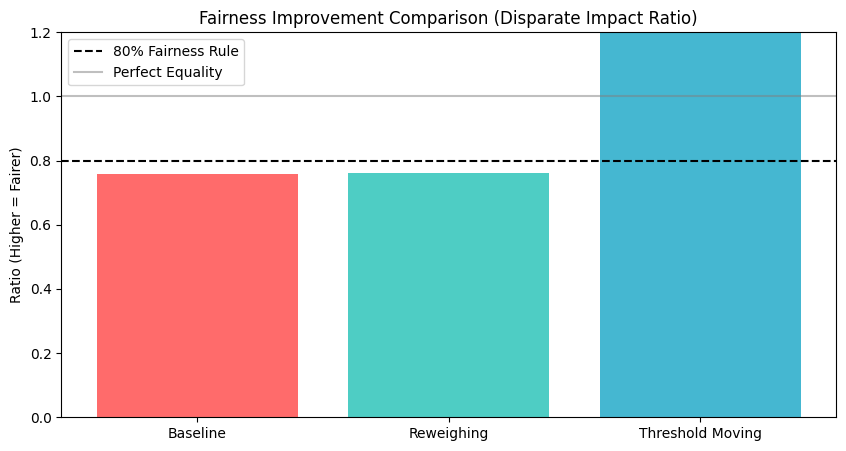

--- BIAS MITIGATION SUMMARY ---
Baseline DI: 0.7594
Reweighing DI: 0.7615
Threshold Moving DI: 1.8562


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# --- 1. PREPARATION ---
# We ensure the target and sensitive attributes are correctly mapped
df['is_mature'] = (df['age'] >= 25).astype(int)
df['is_good_credit'] = (df['credit_score'] == 2).astype(int)

features = ['annual_income', 'monthly_inhand_salary', 'num_bank_accounts',
            'num_credit_card', 'interest_rate', 'outstanding_debt']

X = df[features]
y = df['is_good_credit']
A = df['is_mature']

# Split the data
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, A, test_size=0.3, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Baseline for comparison
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)
baseline_preds = baseline_model.predict(X_test_scaled)

# Calculate Baseline Disparate Impact
def calc_di(predictions, sensitive_attr):
    rate_young = predictions[sensitive_attr == 0].mean()
    rate_mature = predictions[sensitive_attr == 1].mean()
    return rate_young / rate_mature if rate_mature > 0 else 0

baseline_di = calc_di(baseline_preds, A_test.values)

# --- 2. MITIGATION TECHNIQUE 1: REWEIGHING ---
def get_weights(df_subset, sensitive_col, target_col):
    n = len(df_subset)
    n_g = df_subset.groupby(sensitive_col).size()
    n_l = df_subset.groupby(target_col).size()
    n_gl = df_subset.groupby([sensitive_col, target_col]).size()
    weights = np.ones(n)
    for g in [0, 1]:
        for l in [0, 1]:
            expected = (n_g[g] * n_l[l]) / n
            observed = n_gl[g, l]
            weights[(df_subset[sensitive_col].values == g) & (df_subset[target_col].values == l)] = expected / observed
    return weights

train_df = X_train.copy()
train_df['is_mature'] = A_train
train_df['is_good_credit'] = y_train
sample_weights = get_weights(train_df, 'is_mature', 'is_good_credit')

mitigated_model_1 = LogisticRegression(max_iter=1000)
mitigated_model_1.fit(X_train_scaled, y_train, sample_weight=sample_weights)
y_pred_reweigh = mitigated_model_1.predict(X_test_scaled)
di_reweigh = calc_di(y_pred_reweigh, A_test.values)

# --- 3. MITIGATION TECHNIQUE 2: THRESHOLD MOVING (Fixed Syntax) ---
y_probs = baseline_model.predict_proba(X_test_scaled)[:, 1]

# Logic: If Young (0), use 0.35 threshold. If Mature (1), use 0.50 threshold.
y_pred_thresh = []
for prob, group in zip(y_probs, A_test.values):
    threshold = 0.35 if group == 0 else 0.50
    y_pred_thresh.append(1 if prob >= threshold else 0)

y_pred_thresh = np.array(y_pred_thresh)
di_threshold = calc_di(y_pred_thresh, A_test.values)

# --- 4. FINAL COMPARISON VISUALIZATION ---
results = {'Baseline': baseline_di, 'Reweighing': di_reweigh, 'Threshold Moving': di_threshold}
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
plt.axhline(y=0.8, color='black', linestyle='--', label='80% Fairness Rule')
plt.axhline(y=1.0, color='gray', linestyle='-', alpha=0.5, label='Perfect Equality')
plt.title("Fairness Improvement Comparison (Disparate Impact Ratio)")
plt.ylabel("Ratio (Higher = Fairer)")
plt.ylim(0, 1.2)
plt.legend()
plt.show()

print(f"--- BIAS MITIGATION SUMMARY ---")
print(f"Baseline DI: {baseline_di:.4f}")
print(f"Reweighing DI: {di_reweigh:.4f}")
print(f"Threshold Moving DI: {di_threshold:.4f}")